In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image=cv2.imread('training/usimages/car-03.png')

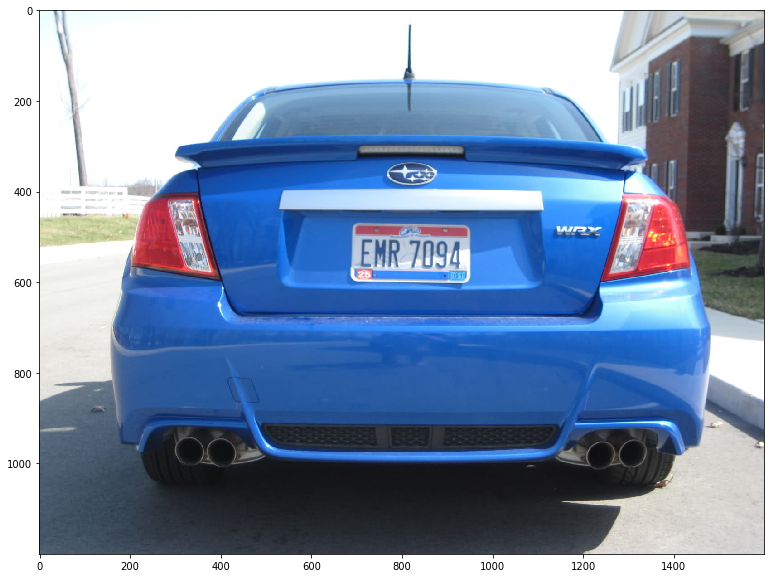

In [3]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [4]:
#image = cv2.resize(image, (640, 480))

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grey scale

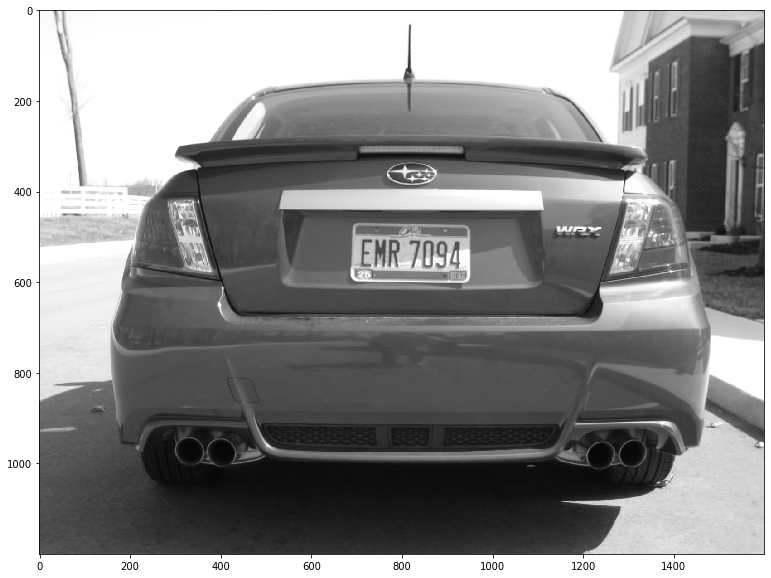

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(gray, cmap='gray')

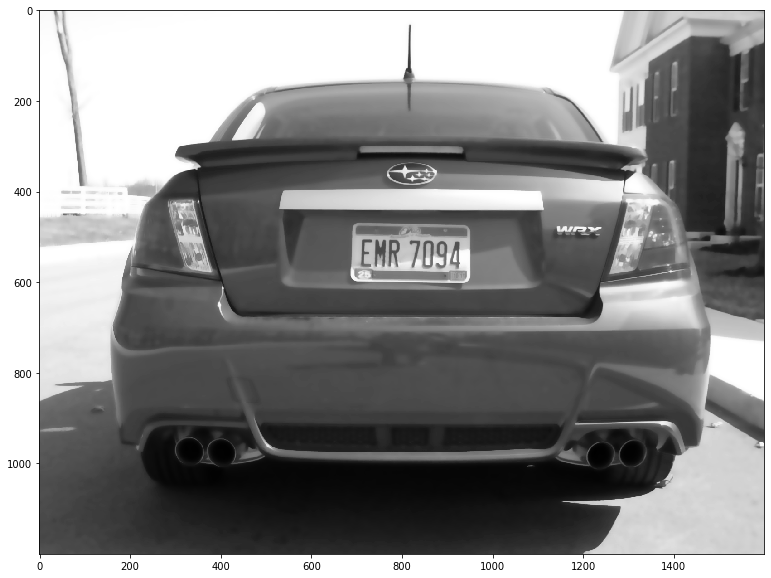

In [6]:
gray = cv2.bilateralFilter(gray, 15, 22, 22)

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(gray, cmap='gray')

In [7]:
# Calculate best parameters for canny edges.
high_thresh, thresh_im = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
lowThresh = 0.5*high_thresh

In [8]:
print(lowThresh, high_thresh)

76.5 153.0


In [9]:
edged = cv2.Canny(gray, lowThresh, high_thresh) #Perform Edge detection

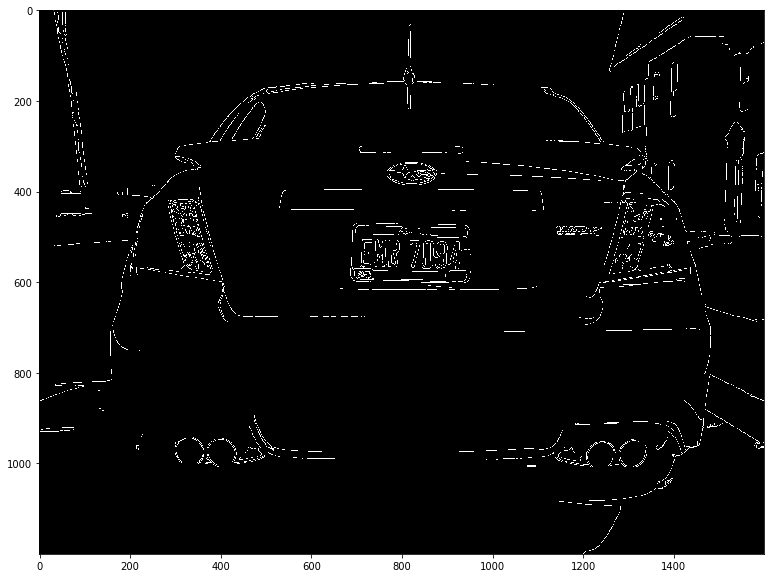

In [10]:
#kernel = np.ones((2,2),np.uint8)
#dilation = cv2.dilate(edged,kernel,iterations = 1)

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(edged, cmap='gray')

In [11]:
_, contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [12]:
import pprint
pp = pprint.PrettyPrinter(indent=10)

candidates = []

i = 0
for c in contours:
    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018 * perimeter, True)
    if len(approx) == 4:
        area = cv2.contourArea(approx)
        perimeter = cv2.contourArea(approx)
        if len(approx) == 4:
            rect = cv2.minAreaRect(approx)
            print(rect)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            candidates.append(box)
            i = i + 1

((1379.0001220703125, 1036.0001220703125), (1.4142134189605713, 1.4142134189605713), -45.0)
((368.9549255371094, 997.4959106445312), (0.9958931803703308, 22.090721130371094), -84.80557250976562)
((1060.3460693359375, 986.7076416015625), (150.65191650390625, 7.4476318359375), -5.33215856552124)
((577.0283813476562, 985.392333984375), (8.835114479064941, 149.85659790039062), -83.87091827392578)
((1406.1351318359375, 950.8742065429688), (6.192645072937012, 55.22679901123047), -31.67546844482422)
((1482.5, 920.5), (1.0, 17.0), -90.0)
((40.39502716064453, 921.883544921875), (77.16216278076172, 3.239929676055908), -3.7152888774871826)
((474.800048828125, 941.60009765625), (2.683281898498535, 53.665626525878906), -26.56505012512207)
((492.00238037109375, 939.0491333007812), (9.482473373413086, 81.835205078125), -32.5248908996582)
((126.50669860839844, 790.8345947265625), (177.51901245117188, 83.23052215576172), -46.141197204589844)
((1474.9041748046875, 731.5964965820312), (143.01400756835938

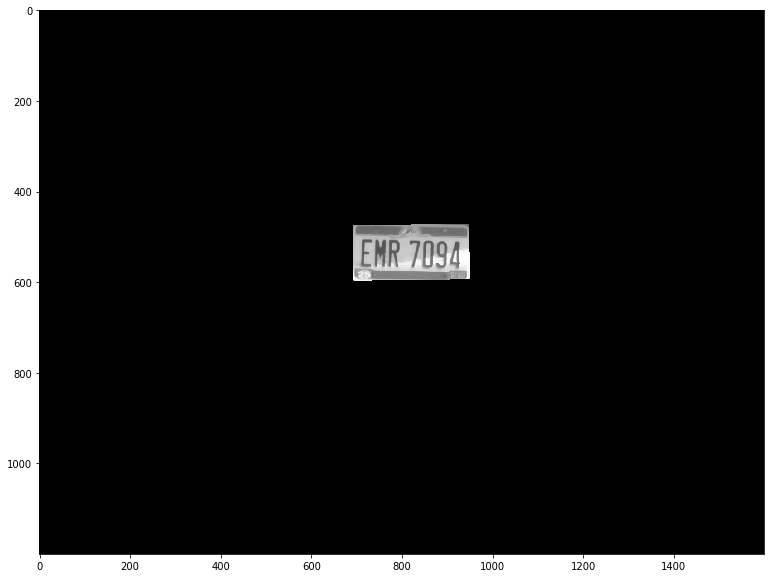

In [13]:
import numpy as np

contour_mask = np.zeros(gray.shape,np.uint8)
cv2.drawContours(contour_mask, [candidates[17]], -1, (255, 255, 255), -1)

img1_bg = cv2.bitwise_and(gray,gray,mask = contour_mask)

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(img1_bg, cmap="gray")

In [14]:
(x, y) = np.where(contour_mask == 255)
(topx, topy) = (np.min(x), np.min(y))
(bottomx, bottomy) = (np.max(x), np.max(y))
cropped_img_gray = gray[topx:bottomx+1, topy:bottomy+1]
cropped_img = image[topx:bottomx+1, topy:bottomy+1]

cropped_img_gray = cv2.resize(cropped_img_gray, (500, 300))
cropped_img = cv2.resize(cropped_img, (500, 300))

In [16]:
cv2.imwrite("cropped_img.png", cropped_img)
cv2.imwrite("cropped_img_gray.png", cropped_img_gray)

True